In [20]:
import pandas as pd
from dataprep.eda import create_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [21]:
def get_cardio_category(gender, age, vo2max):
    if pd.isna(gender):
        return np.nan
    if gender == "MALE":
        if age == "<30":
            if vo2max >= 51.1:
                return 2
            elif vo2max >= 41.7:
                return 1
            else:
                return 0
        else:
            if vo2max >= 48.3:
                return 2
            elif vo2max >= 40.5:
                return 1
            else:
                return 0
    else:
        if age == "<30":
            if vo2max >= 43.9:
                return 2
            elif vo2max >= 36.1:
                return 1
            else:
                return 0
        else:
            if vo2max >= 42.4:
                return 2
            elif vo2max >= 34.4:
                return 1
            else:
                return 0

In [22]:
def one_hot_encoding(fitbit):
    # badgeType encoding
    s = fitbit['badgeType']
    dum = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
    df = pd.concat([s, dum], axis=1)
    fitbit = pd.concat([fitbit, df], axis=1)
    fitbit = fitbit.drop(columns='badgeType')

    # activity type encoding
    s = fitbit['activityType']
    dum = pd.get_dummies(s.apply(pd.Series).stack()).sum(level=0)
    df = pd.concat([s, dum], axis=1)
    fitbit = pd.concat([fitbit, df], axis=1)
    fitbit = fitbit.drop(columns='activityType')

    # mindfulness session encoding - highly imbalanced
    fitbit['mindfulness_session'].replace(to_replace=['False', True], value=[0, 1], inplace=True)

    # age encoding
    fitbit['age'].replace(to_replace=['<30', '>=30'], value=[0, 1], inplace=True)

    # gender encoding
    fitbit['gender'].replace(to_replace=['MALE', 'FEMALE'], value=[0, 1], inplace=True)

    # bmi encoding
    fitbit['bmi'] = fitbit['bmi'].fillna(fitbit['bmi'].mode().iloc[0])
    fitbit["bmi"] = fitbit["bmi"].apply(lambda x: 31.0 if x == '>=30' else x)
    fitbit["bmi"] = fitbit["bmi"].apply(lambda x: 18.0 if x == '<19' else x)
    fitbit["bmi"] = fitbit["bmi"].apply(lambda x: 26.0 if x == '>=25' else x)  # it belongs to overweight
    fitbit["bmi"] = fitbit["bmi"].apply(lambda x: 31 if x == '>=30' else x)
    fitbit['bmi'] = fitbit.bmi.apply(lambda bmi: 'Underweight' if bmi < 18.5 else ('Normal' if bmi < 25 else (
        'Overweight' if bmi < 30 else 'Obese')))  # 0: Underweight, 1: Normal, 2: Overweight, 3: Obese

    # ECG alert encoding
    fitbit['heart_rate_alert'].replace(to_replace=['NONE', 'LOW_HR'], value=[0, 1], inplace=True)

    return fitbit


In [23]:
df=pd.read_pickle('../data/unified_dataframe/data_unprocessed.pkl')
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,label_ttm_stage,label_breq_self_determination,label_sema_negative_feelings,label_ipip_extraversion_category,label_ipip_agreeableness_category,label_ipip_conscientiousness_category,label_ipip_stability_category,label_ipip_intellect_category,label_stai_stress_category,label_panas_negative_affect
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,Maintenance,intrinsic_regulation,NaN,LOW,LOW,HIGH,HIGH,AVERAGE,NaN,NaN
1,621e328667b776a240281372,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Maintenance,intrinsic_regulation,NaN,HIGH,AVERAGE,HIGH,LOW,LOW,NaN,NaN
2,621e326767b776a24012e179,2021-05-24,NaN,46.120,53.968,95.3,14.4,80.0,0.666667,0.925,...,Maintenance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,621e332267b776a24092a584,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Maintenance,identified_regulation,NaN,LOW,LOW,LOW,AVERAGE,HIGH,NaN,NaN
4,621e333567b776a240a0c217,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Contemplation,intrinsic_regulation,NaN,AVERAGE,HIGH,AVERAGE,LOW,LOW,NaN,NaN


In [24]:
df['fitness'] = df.apply(lambda row: get_cardio_category(row["gender"], row['age'], row["filteredDemographicVO2Max"]), axis=1)
df.fitness.astype(str)
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,label_breq_self_determination,label_sema_negative_feelings,label_ipip_extraversion_category,label_ipip_agreeableness_category,label_ipip_conscientiousness_category,label_ipip_stability_category,label_ipip_intellect_category,label_stai_stress_category,label_panas_negative_affect,fitness
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,intrinsic_regulation,NaN,LOW,LOW,HIGH,HIGH,AVERAGE,NaN,NaN,2.0
1,621e328667b776a240281372,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,intrinsic_regulation,NaN,HIGH,AVERAGE,HIGH,LOW,LOW,NaN,NaN,1.0
2,621e326767b776a24012e179,2021-05-24,NaN,46.120,53.968,95.3,14.4,80.0,0.666667,0.925,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
3,621e332267b776a24092a584,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,identified_regulation,NaN,LOW,LOW,LOW,AVERAGE,HIGH,NaN,NaN,2.0
4,621e333567b776a240a0c217,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,intrinsic_regulation,NaN,AVERAGE,HIGH,AVERAGE,LOW,LOW,NaN,NaN,0.0


In [25]:
df = one_hot_encoding(df)
df.head()

,id,date,nightly_temperature,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,sleep_points_percentage,exertion_points_percentage,...,Martial Arts,Run,Spinning,Sport,Swim,Treadmill,Walk,Weights,Workout,Yoga/Pilates
0,621e2e8e67b776a24055b564,2021-05-24,34.137687,57.432,89.603,NaN,14.8,78.0,0.833333,0.675,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,621e328667b776a240281372,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,621e326767b776a24012e179,2021-05-24,NaN,46.120,53.968,95.3,14.4,80.0,0.666667,0.925,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,621e332267b776a24092a584,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,621e333567b776a240a0c217,2021-05-24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df = df.replace(['Maintenance', 'Contemplation', 'Action', 'Preparation', 'Precontemplation', 'intrinsic_regulation', 'identified_regulation', 'introjected_regulation', 'amotivation', 'AVERAGE', 'LOW', 'HIGH','Below average', 'Average', 'Above average', 'Underweight', 'Normal', 'Overweight', 'Obese'], [0, 1, 2, 3, 4, 0, 1, 2, 3, 0, 1, 2, 0, 1, 2, 0, 1, 2, 3])

In [27]:
df = df[['nremhr', 'rmssd', 'spo2',
       'full_sleep_breathing_rate', 'stress_score','daily_temperature_variation', 'calories', 'distance', 'bpm',
       'lightly_active_minutes', 'moderately_active_minutes',
       'very_active_minutes', 'sedentary_minutes', 'mindfulness_session', 'resting_hr', 'sleep_duration', 'steps', 'age',
       'gender','fitness', 'startTime', 'endTime',
       'label_ipip_extraversion_category',
       'label_ipip_agreeableness_category',
       'label_ipip_conscientiousness_category',
       'label_ipip_stability_category', 'label_ipip_intellect_category','label_sema_negative_feelings',
       'label_stai_stress_category', 'label_panas_negative_affect']]

In [28]:
correlation_matrix = df.corr().round(2)
correlation_matrix

,nremhr,rmssd,spo2,full_sleep_breathing_rate,stress_score,daily_temperature_variation,calories,distance,bpm,lightly_active_minutes,...,gender,fitness,label_ipip_extraversion_category,label_ipip_agreeableness_category,label_ipip_conscientiousness_category,label_ipip_stability_category,label_ipip_intellect_category,label_sema_negative_feelings,label_stai_stress_category,label_panas_negative_affect
nremhr,1.00,-0.41,-0.02,0.38,0.14,0.08,-0.17,-0.18,0.51,-0.07,...,-0.00,-0.27,0.21,0.33,-0.27,-0.00,-0.08,0.08,-0.01,-0.25
rmssd,-0.41,1.00,-0.06,-0.02,0.15,-0.05,0.31,0.19,-0.42,0.13,...,-0.17,0.21,0.05,-0.28,0.61,-0.02,0.11,-0.03,-0.24,-0.17
spo2,-0.02,-0.06,1.00,0.10,0.07,-0.11,-0.01,0.02,-0.10,-0.04,...,0.04,0.05,-0.25,-0.29,0.09,-0.05,-0.24,-0.06,-0.08,-0.20
full_sleep_breathing_rate,0.38,-0.02,0.10,1.00,0.11,-0.07,-0.10,-0.02,0.08,0.00,...,0.19,0.02,-0.05,0.04,-0.02,-0.22,0.05,-0.02,0.14,-0.05
stress_score,0.14,0.15,0.07,0.11,1.00,-0.05,-0.03,0.12,-0.08,0.24,...,0.01,0.12,0.03,0.16,-0.04,-0.07,0.05,-0.02,0.14,0.06
daily_temperature_variation,0.08,-0.05,-0.11,-0.07,-0.05,1.00,0.10,-0.11,-0.01,-0.25,...,-0.39,0.03,0.09,-0.21,0.07,0.22,0.08,-0.02,0.22,-0.10
calories,-0.17,0.31,-0.01,-0.10,-0.03,0.10,1.00,0.65,0.16,0.52,...,-0.38,0.23,-0.06,-0.07,0.32,0.06,-0.04,0.03,-0.03,-0.06
distance,-0.18,0.19,0.02,-0.02,0.12,-0.11,0.65,1.00,0.11,0.59,...,-0.01,0.12,-0.14,-0.01,0.12,-0.07,0.03,-0.03,0.07,-0.01
bpm,0.51,-0.42,-0.10,0.08,-0.08,-0.01,0.16,0.11,1.00,0.03,...,0.06,-0.28,0.17,0.09,-0.12,-0.09,-0.03,0.03,0.14,0.03
lightly_active_minutes,-0.07,0.13,-0.04,0.00,0.24,-0.25,0.52,0.59,0.03,1.00,...,0.18,0.42,-0.14,-0.00,0.15,-0.04,0.12,0.04,-0.19,0.04


In [29]:
correlation_matrix = correlation_matrix.loc['nremhr': 'steps', 'age': 'label_panas_negative_affect']
correlation_matrix

,age,gender,fitness,label_ipip_extraversion_category,label_ipip_agreeableness_category,label_ipip_conscientiousness_category,label_ipip_stability_category,label_ipip_intellect_category,label_sema_negative_feelings,label_stai_stress_category,label_panas_negative_affect
nremhr,0.04,-0.00,-0.27,0.21,0.33,-0.27,-0.00,-0.08,0.08,-0.01,-0.25
rmssd,-0.07,-0.17,0.21,0.05,-0.28,0.61,-0.02,0.11,-0.03,-0.24,-0.17
spo2,0.08,0.04,0.05,-0.25,-0.29,0.09,-0.05,-0.24,-0.06,-0.08,-0.20
full_sleep_breathing_rate,-0.18,0.19,0.02,-0.05,0.04,-0.02,-0.22,0.05,-0.02,0.14,-0.05
stress_score,0.06,0.01,0.12,0.03,0.16,-0.04,-0.07,0.05,-0.02,0.14,0.06
daily_temperature_variation,0.03,-0.39,0.03,0.09,-0.21,0.07,0.22,0.08,-0.02,0.22,-0.10
calories,0.08,-0.38,0.23,-0.06,-0.07,0.32,0.06,-0.04,0.03,-0.03,-0.06
distance,0.04,-0.01,0.12,-0.14,-0.01,0.12,-0.07,0.03,-0.03,0.07,-0.01
bpm,-0.01,0.06,-0.28,0.17,0.09,-0.12,-0.09,-0.03,0.03,0.14,0.03
lightly_active_minutes,0.20,0.18,0.42,-0.14,-0.00,0.15,-0.04,0.12,0.04,-0.19,0.04


In [30]:
correlation_matrix.columns

Index(['age', 'gender', 'fitness', 'label_ipip_extraversion_category',
       'label_ipip_agreeableness_category',
       'label_ipip_conscientiousness_category',
       'label_ipip_stability_category', 'label_ipip_intellect_category',
       'label_sema_negative_feelings', 'label_stai_stress_category',
       'label_panas_negative_affect'],
      dtype='object')

In [31]:
correlation_matrix.rename(columns={"label_ttm_stage": "ttm_stage", "label_sema_negative_feelings":"sema", "label_ipip_extraversion_category":"extraversion",
                                  "label_ipip_agreeableness_category":"agreeableness", "label_ipip_conscientiousness_category":"conscientiousness",
                                  "label_ipip_stability_category":"stability", "label_ipip_intellect_category":"intellect", "label_stai_stress_category":"stai", "label_panas_negative_affect":"panas"}, inplace=True)

group the features of the y-axis

In [32]:
temp = correlation_matrix
temp

,age,gender,fitness,extraversion,agreeableness,conscientiousness,stability,intellect,sema,stai,panas
nremhr,0.04,-0.00,-0.27,0.21,0.33,-0.27,-0.00,-0.08,0.08,-0.01,-0.25
rmssd,-0.07,-0.17,0.21,0.05,-0.28,0.61,-0.02,0.11,-0.03,-0.24,-0.17
spo2,0.08,0.04,0.05,-0.25,-0.29,0.09,-0.05,-0.24,-0.06,-0.08,-0.20
full_sleep_breathing_rate,-0.18,0.19,0.02,-0.05,0.04,-0.02,-0.22,0.05,-0.02,0.14,-0.05
stress_score,0.06,0.01,0.12,0.03,0.16,-0.04,-0.07,0.05,-0.02,0.14,0.06
daily_temperature_variation,0.03,-0.39,0.03,0.09,-0.21,0.07,0.22,0.08,-0.02,0.22,-0.10
calories,0.08,-0.38,0.23,-0.06,-0.07,0.32,0.06,-0.04,0.03,-0.03,-0.06
distance,0.04,-0.01,0.12,-0.14,-0.01,0.12,-0.07,0.03,-0.03,0.07,-0.01
bpm,-0.01,0.06,-0.28,0.17,0.09,-0.12,-0.09,-0.03,0.03,0.14,0.03
lightly_active_minutes,0.20,0.18,0.42,-0.14,-0.00,0.15,-0.04,0.12,0.04,-0.19,0.04


In [33]:
temp.reset_index(inplace=True)
temp

,index,age,gender,fitness,extraversion,agreeableness,conscientiousness,stability,intellect,sema,stai,panas
0,nremhr,0.04,-0.00,-0.27,0.21,0.33,-0.27,-0.00,-0.08,0.08,-0.01,-0.25
1,rmssd,-0.07,-0.17,0.21,0.05,-0.28,0.61,-0.02,0.11,-0.03,-0.24,-0.17
2,spo2,0.08,0.04,0.05,-0.25,-0.29,0.09,-0.05,-0.24,-0.06,-0.08,-0.20
3,full_sleep_breathing_rate,-0.18,0.19,0.02,-0.05,0.04,-0.02,-0.22,0.05,-0.02,0.14,-0.05
4,stress_score,0.06,0.01,0.12,0.03,0.16,-0.04,-0.07,0.05,-0.02,0.14,0.06
5,daily_temperature_variation,0.03,-0.39,0.03,0.09,-0.21,0.07,0.22,0.08,-0.02,0.22,-0.10
6,calories,0.08,-0.38,0.23,-0.06,-0.07,0.32,0.06,-0.04,0.03,-0.03,-0.06
7,distance,0.04,-0.01,0.12,-0.14,-0.01,0.12,-0.07,0.03,-0.03,0.07,-0.01
8,bpm,-0.01,0.06,-0.28,0.17,0.09,-0.12,-0.09,-0.03,0.03,0.14,0.03
9,lightly_active_minutes,0.20,0.18,0.42,-0.14,-0.00,0.15,-0.04,0.12,0.04,-0.19,0.04


In [34]:
temp.iloc[2], temp.loc[15] = temp.loc[15].copy(), temp.loc[2].copy()
temp

,index,age,gender,fitness,extraversion,agreeableness,conscientiousness,stability,intellect,sema,stai,panas
0,nremhr,0.04,-0.00,-0.27,0.21,0.33,-0.27,-0.00,-0.08,0.08,-0.01,-0.25
1,rmssd,-0.07,-0.17,0.21,0.05,-0.28,0.61,-0.02,0.11,-0.03,-0.24,-0.17
2,sleep_duration,-0.14,0.09,0.07,-0.06,0.03,-0.11,-0.01,0.02,-0.05,0.01,0.02
3,full_sleep_breathing_rate,-0.18,0.19,0.02,-0.05,0.04,-0.02,-0.22,0.05,-0.02,0.14,-0.05
4,stress_score,0.06,0.01,0.12,0.03,0.16,-0.04,-0.07,0.05,-0.02,0.14,0.06
5,daily_temperature_variation,0.03,-0.39,0.03,0.09,-0.21,0.07,0.22,0.08,-0.02,0.22,-0.10
6,calories,0.08,-0.38,0.23,-0.06,-0.07,0.32,0.06,-0.04,0.03,-0.03,-0.06
7,distance,0.04,-0.01,0.12,-0.14,-0.01,0.12,-0.07,0.03,-0.03,0.07,-0.01
8,bpm,-0.01,0.06,-0.28,0.17,0.09,-0.12,-0.09,-0.03,0.03,0.14,0.03
9,lightly_active_minutes,0.20,0.18,0.42,-0.14,-0.00,0.15,-0.04,0.12,0.04,-0.19,0.04


In [35]:
temp.iloc[7], temp.loc[8] = temp.loc[8].copy(), temp.loc[7].copy()
temp

,index,age,gender,fitness,extraversion,agreeableness,conscientiousness,stability,intellect,sema,stai,panas
0,nremhr,0.04,-0.00,-0.27,0.21,0.33,-0.27,-0.00,-0.08,0.08,-0.01,-0.25
1,rmssd,-0.07,-0.17,0.21,0.05,-0.28,0.61,-0.02,0.11,-0.03,-0.24,-0.17
2,sleep_duration,-0.14,0.09,0.07,-0.06,0.03,-0.11,-0.01,0.02,-0.05,0.01,0.02
3,full_sleep_breathing_rate,-0.18,0.19,0.02,-0.05,0.04,-0.02,-0.22,0.05,-0.02,0.14,-0.05
4,stress_score,0.06,0.01,0.12,0.03,0.16,-0.04,-0.07,0.05,-0.02,0.14,0.06
5,daily_temperature_variation,0.03,-0.39,0.03,0.09,-0.21,0.07,0.22,0.08,-0.02,0.22,-0.10
6,calories,0.08,-0.38,0.23,-0.06,-0.07,0.32,0.06,-0.04,0.03,-0.03,-0.06
7,bpm,-0.01,0.06,-0.28,0.17,0.09,-0.12,-0.09,-0.03,0.03,0.14,0.03
8,distance,0.04,-0.01,0.12,-0.14,-0.01,0.12,-0.07,0.03,-0.03,0.07,-0.01
9,lightly_active_minutes,0.20,0.18,0.42,-0.14,-0.00,0.15,-0.04,0.12,0.04,-0.19,0.04


In [36]:
temp.iloc[13], temp.loc[16] = temp.loc[16].copy(), temp.loc[13].copy()
temp

,index,age,gender,fitness,extraversion,agreeableness,conscientiousness,stability,intellect,sema,stai,panas
0,nremhr,0.04,-0.00,-0.27,0.21,0.33,-0.27,-0.00,-0.08,0.08,-0.01,-0.25
1,rmssd,-0.07,-0.17,0.21,0.05,-0.28,0.61,-0.02,0.11,-0.03,-0.24,-0.17
2,sleep_duration,-0.14,0.09,0.07,-0.06,0.03,-0.11,-0.01,0.02,-0.05,0.01,0.02
3,full_sleep_breathing_rate,-0.18,0.19,0.02,-0.05,0.04,-0.02,-0.22,0.05,-0.02,0.14,-0.05
4,stress_score,0.06,0.01,0.12,0.03,0.16,-0.04,-0.07,0.05,-0.02,0.14,0.06
5,daily_temperature_variation,0.03,-0.39,0.03,0.09,-0.21,0.07,0.22,0.08,-0.02,0.22,-0.10
6,calories,0.08,-0.38,0.23,-0.06,-0.07,0.32,0.06,-0.04,0.03,-0.03,-0.06
7,bpm,-0.01,0.06,-0.28,0.17,0.09,-0.12,-0.09,-0.03,0.03,0.14,0.03
8,distance,0.04,-0.01,0.12,-0.14,-0.01,0.12,-0.07,0.03,-0.03,0.07,-0.01
9,lightly_active_minutes,0.20,0.18,0.42,-0.14,-0.00,0.15,-0.04,0.12,0.04,-0.19,0.04


In [37]:
temp.iloc[4], temp.loc[15] = temp.loc[15].copy(), temp.loc[4].copy()
temp

,index,age,gender,fitness,extraversion,agreeableness,conscientiousness,stability,intellect,sema,stai,panas
0,nremhr,0.04,-0.00,-0.27,0.21,0.33,-0.27,-0.00,-0.08,0.08,-0.01,-0.25
1,rmssd,-0.07,-0.17,0.21,0.05,-0.28,0.61,-0.02,0.11,-0.03,-0.24,-0.17
2,sleep_duration,-0.14,0.09,0.07,-0.06,0.03,-0.11,-0.01,0.02,-0.05,0.01,0.02
3,full_sleep_breathing_rate,-0.18,0.19,0.02,-0.05,0.04,-0.02,-0.22,0.05,-0.02,0.14,-0.05
4,spo2,0.08,0.04,0.05,-0.25,-0.29,0.09,-0.05,-0.24,-0.06,-0.08,-0.20
5,daily_temperature_variation,0.03,-0.39,0.03,0.09,-0.21,0.07,0.22,0.08,-0.02,0.22,-0.10
6,calories,0.08,-0.38,0.23,-0.06,-0.07,0.32,0.06,-0.04,0.03,-0.03,-0.06
7,bpm,-0.01,0.06,-0.28,0.17,0.09,-0.12,-0.09,-0.03,0.03,0.14,0.03
8,distance,0.04,-0.01,0.12,-0.14,-0.01,0.12,-0.07,0.03,-0.03,0.07,-0.01
9,lightly_active_minutes,0.20,0.18,0.42,-0.14,-0.00,0.15,-0.04,0.12,0.04,-0.19,0.04


In [38]:
temp.iloc[8], temp.loc[14] = temp.loc[14].copy(), temp.loc[8].copy()
temp

,index,age,gender,fitness,extraversion,agreeableness,conscientiousness,stability,intellect,sema,stai,panas
0,nremhr,0.04,-0.00,-0.27,0.21,0.33,-0.27,-0.00,-0.08,0.08,-0.01,-0.25
1,rmssd,-0.07,-0.17,0.21,0.05,-0.28,0.61,-0.02,0.11,-0.03,-0.24,-0.17
2,sleep_duration,-0.14,0.09,0.07,-0.06,0.03,-0.11,-0.01,0.02,-0.05,0.01,0.02
3,full_sleep_breathing_rate,-0.18,0.19,0.02,-0.05,0.04,-0.02,-0.22,0.05,-0.02,0.14,-0.05
4,spo2,0.08,0.04,0.05,-0.25,-0.29,0.09,-0.05,-0.24,-0.06,-0.08,-0.20
5,daily_temperature_variation,0.03,-0.39,0.03,0.09,-0.21,0.07,0.22,0.08,-0.02,0.22,-0.10
6,calories,0.08,-0.38,0.23,-0.06,-0.07,0.32,0.06,-0.04,0.03,-0.03,-0.06
7,bpm,-0.01,0.06,-0.28,0.17,0.09,-0.12,-0.09,-0.03,0.03,0.14,0.03
8,resting_hr,0.06,0.06,-0.43,0.21,0.22,-0.23,-0.10,-0.05,0.02,0.13,-0.06
9,lightly_active_minutes,0.20,0.18,0.42,-0.14,-0.00,0.15,-0.04,0.12,0.04,-0.19,0.04


In [40]:
temp.set_index('index', inplace=True)
temp

,age,gender,fitness,extraversion,agreeableness,conscientiousness,stability,intellect,sema,stai,panas
index,,,,,,,,,,,
nremhr,0.04,-0.00,-0.27,0.21,0.33,-0.27,-0.00,-0.08,0.08,-0.01,-0.25
rmssd,-0.07,-0.17,0.21,0.05,-0.28,0.61,-0.02,0.11,-0.03,-0.24,-0.17
sleep_duration,-0.14,0.09,0.07,-0.06,0.03,-0.11,-0.01,0.02,-0.05,0.01,0.02
full_sleep_breathing_rate,-0.18,0.19,0.02,-0.05,0.04,-0.02,-0.22,0.05,-0.02,0.14,-0.05
spo2,0.08,0.04,0.05,-0.25,-0.29,0.09,-0.05,-0.24,-0.06,-0.08,-0.20
daily_temperature_variation,0.03,-0.39,0.03,0.09,-0.21,0.07,0.22,0.08,-0.02,0.22,-0.10
calories,0.08,-0.38,0.23,-0.06,-0.07,0.32,0.06,-0.04,0.03,-0.03,-0.06
bpm,-0.01,0.06,-0.28,0.17,0.09,-0.12,-0.09,-0.03,0.03,0.14,0.03
resting_hr,0.06,0.06,-0.43,0.21,0.22,-0.23,-0.10,-0.05,0.02,0.13,-0.06


In [41]:
cmap = ["#4C72B0", "#55A868", "#C44E52",
          "#8172B2", "#CCB974", "#64B5CD"]
sns.set_palette(sns.color_palette(cmap))

##### grouped

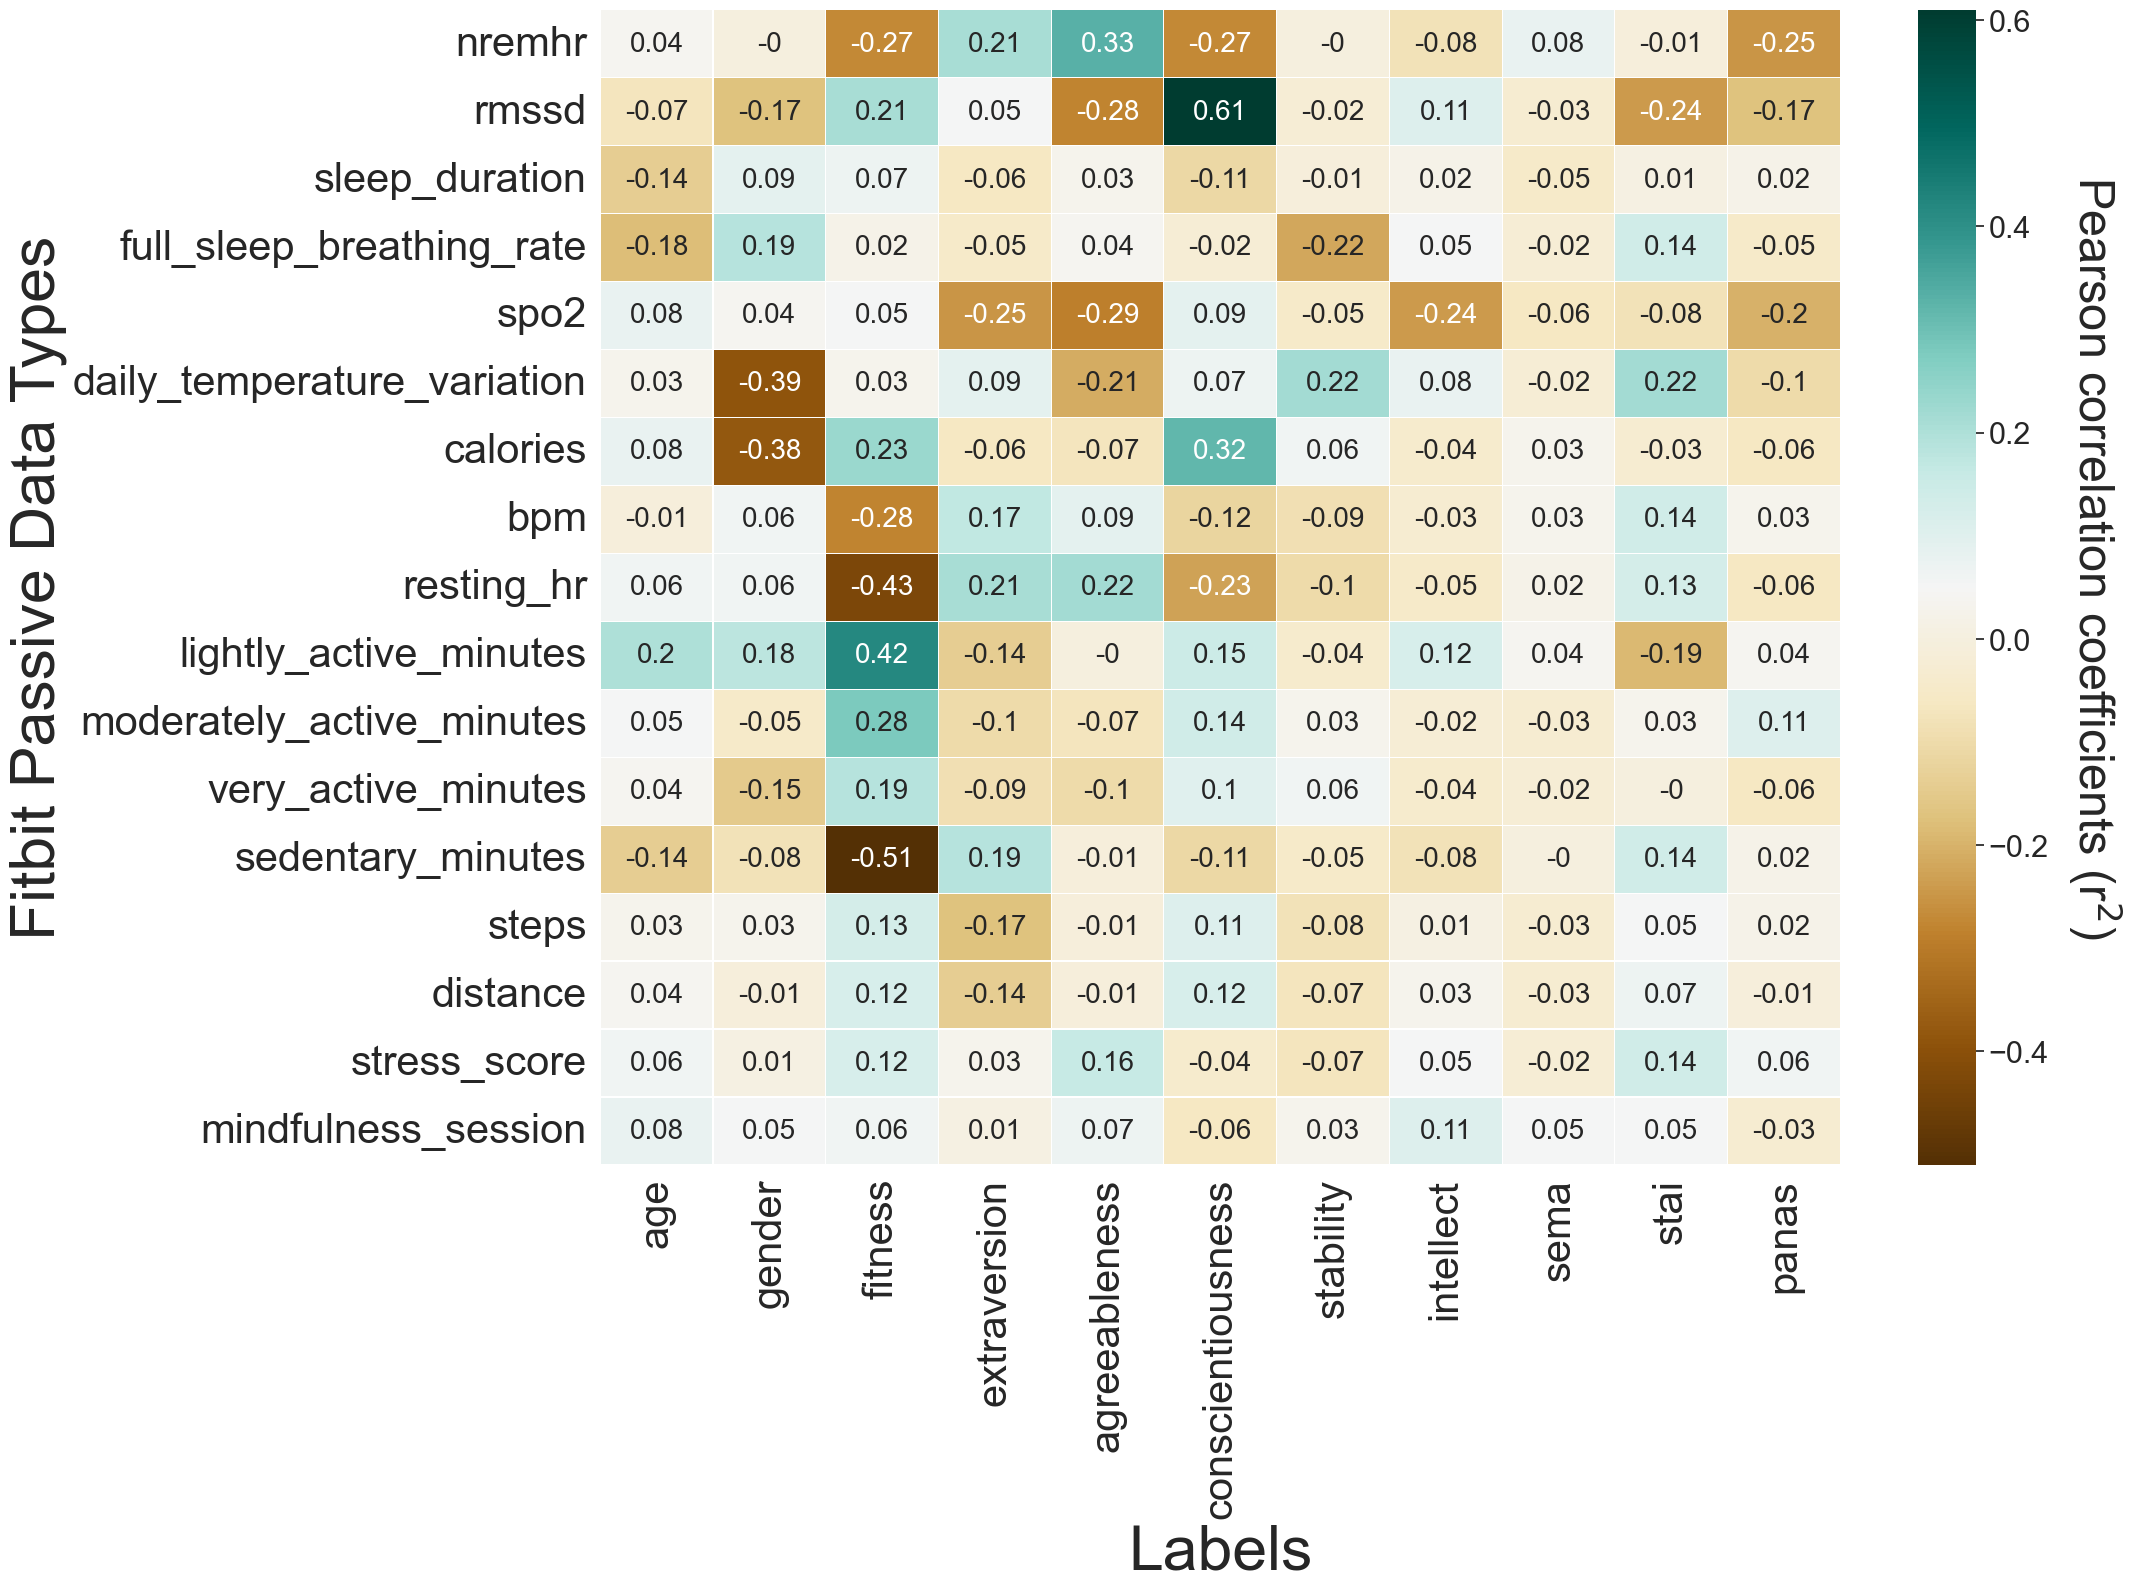

In [42]:
fig = plt.gcf()
fig.set_size_inches(20, 15)
sns.set(font_scale = 2)
sns.heatmap(data=temp, annot=True,cmap='BrBG', annot_kws={"size":20}, linewidths=0.1)
plt.xlabel('Labels', fontsize=45)
plt.ylabel('Fitbit Passive Data Types', fontsize=45)
plt.text(13, 13.5, 'Pearson correlation coefficients (r$^2$)', rotation=270, fontsize=35)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.savefig("visualizations/grouped_correlation_matrix_labels_vs_features.png",bbox_inches='tight')
plt.savefig("visualizations/grouped_correlation_matrix_labels_vs_features.eps",bbox_inches='tight')
plt.show()